In [0]:
from google.colab import drive

In [0]:
from google.colab import files

In [0]:
!pip install -q kaggle

In [27]:
ls

kaggle.json


In [29]:
cd '/root/.kaggle'

/root/.kaggle


In [30]:
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [31]:
cd "/content/drive/My Drive/Colab Notebooks/NFL data visualization/NFL-injury-dataset"

/content/drive/My Drive/Colab Notebooks/NFL data visualization/NFL-injury-dataset


In [32]:
ls

README.md


In [33]:
!kaggle competitions download -c nfl-playing-surface-analytics

  0% 0.00/1.51M [00:00<?, ?B/s]
100% 1.51M/1.51M [00:00<00:00, 52.0MB/s]
 99% 1.06G/1.07G [00:13<00:00, 97.9MB/s]
100% 1.07G/1.07G [00:13<00:00, 86.3MB/s]
  0% 0.00/4.81k [00:00<?, ?B/s]
100% 4.81k/4.81k [00:00<00:00, 1.31MB/s]


In [34]:
ls

InjuryRecord.csv  PlayerTrackData.csv.zip  PlayList.csv.zip  README.md


In [0]:
import numpy as np
import pandas as pd

import matplotlib.patches as patches
import matplotlib.pyplot as plt
%matplotlib inline

import zipfile

In [36]:
#loading the data, we have 105 injuries in the dataset
injury_df = pd.read_csv('InjuryRecord.csv')
injury_df.head()
#injury_df.info()

,PlayerKey,GameID,PlayKey,BodyPart,Surface,DM_M1,DM_M7,DM_M28,DM_M42
0,39873,39873-4,39873-4-32,Knee,Synthetic,1,1,1,1
1,46074,46074-7,46074-7-26,Knee,Natural,1,1,0,0
2,36557,36557-1,36557-1-70,Ankle,Synthetic,1,1,1,1
3,46646,46646-3,46646-3-30,Ankle,Natural,1,0,0,0
4,43532,43532-5,43532-5-69,Ankle,Synthetic,1,1,1,1


In [37]:
#we have 28 injuries without PlayKey value, the rest of dataframe is complete
for feature in injury_df.columns:
    print(feature,'Number of missing values: ', injury_df[feature].isnull().sum())
    print('-------------------------------------')

PlayerKey Number of missing values:  0
-------------------------------------
GameID Number of missing values:  0
-------------------------------------
PlayKey Number of missing values:  28
-------------------------------------
BodyPart Number of missing values:  0
-------------------------------------
Surface Number of missing values:  0
-------------------------------------
DM_M1 Number of missing values:  0
-------------------------------------
DM_M7 Number of missing values:  0
-------------------------------------
DM_M28 Number of missing values:  0
-------------------------------------
DM_M42 Number of missing values:  0
-------------------------------------


In [0]:
#let's fill missing PlayKey data with 'GameID-1' values
injury_df['new']='-1'
injury_df['PlayKey'].fillna(injury_df['GameID']+injury_df['new'], inplace=True)
del injury_df['new']

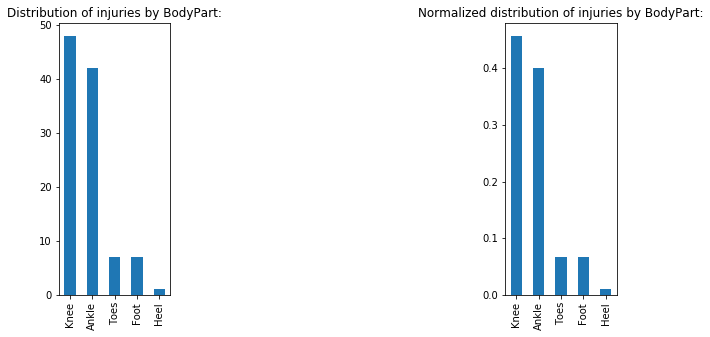

In [39]:
#let's check distribution of injuries by Bodypart
plt.subplots_adjust(wspace = 3)
plt.subplot(1,2,1)
injury_df['BodyPart'].value_counts().plot(kind='bar', title='Distribution of injuries by BodyPart:', figsize=(10,5))
#normalized distribution
plt.subplot(1,2,2)
injury_df['BodyPart'].value_counts(normalize=True).plot(kind='bar', title='Normalized distribution of injuries by BodyPart:', figsize=(10,5))
plt.show()

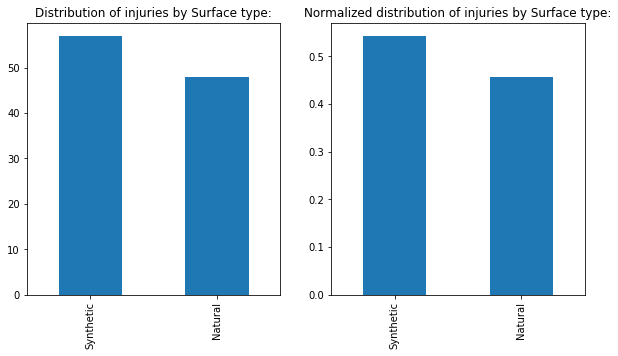

<function matplotlib.pyplot.tight_layout>

In [40]:
#let's check distribution of injuries by Surface (more injuries on Synthetic surface)
plt.subplot(1,2,1)
injury_df['Surface'].value_counts().plot(kind='bar', title='Distribution of injuries by Surface type:', figsize=(10,5))
#normalized distribution
plt.subplot(1,2,2)
injury_df['Surface'].value_counts(normalize=True).plot(kind='bar', \
            title='Normalized distribution of injuries by Surface type:', figsize=(10,5))
plt.show()
plt.tight_layout

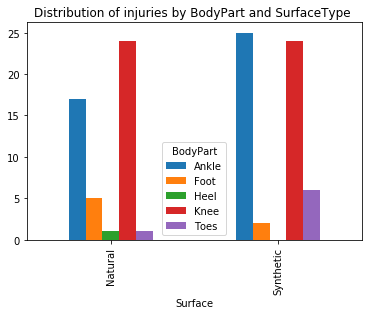

In [41]:
#let's put both diagrams into one
injury_df.groupby(['BodyPart', 'Surface']).count().unstack('BodyPart')['PlayerKey']\
    .plot(kind='bar', title='Distribution of injuries by BodyPart and SurfaceType ')

In [42]:
#let's create new features to categorize injury severity 
def map_injury_level(x):
    if x == 1: return 'light'
    if x == 2: return 'medium'
    if x == 3: return 'severe'
    if x == 4: return 'very severe'
    return 'unknown'

injury_df['InjuryLevel']=injury_df[['DM_M1','DM_M7','DM_M28','DM_M42']].sum(axis=1)
injury_df['InjuryLevel_cat']=injury_df['InjuryLevel'].map(map_injury_level)
injury_df.head(10)

,PlayerKey,GameID,PlayKey,BodyPart,Surface,DM_M1,DM_M7,DM_M28,DM_M42,InjuryLevel,InjuryLevel_cat
0,39873,39873-4,39873-4-32,Knee,Synthetic,1,1,1,1,4,very severe
1,46074,46074-7,46074-7-26,Knee,Natural,1,1,0,0,2,medium
2,36557,36557-1,36557-1-70,Ankle,Synthetic,1,1,1,1,4,very severe
3,46646,46646-3,46646-3-30,Ankle,Natural,1,0,0,0,1,light
4,43532,43532-5,43532-5-69,Ankle,Synthetic,1,1,1,1,4,very severe
5,41145,41145-2,41145-2-60,Knee,Natural,1,0,0,0,1,light
6,46014,46014-10,46014-10-22,Ankle,Synthetic,1,1,1,1,4,very severe
7,44860,44860-5,44860-5-52,Knee,Natural,1,1,0,0,2,medium
8,44806,44806-7,44806-7-61,Knee,Synthetic,1,0,0,0,1,light
9,45962,45962-8,45962-8-40,Ankle,Synthetic,1,1,0,0,2,medium


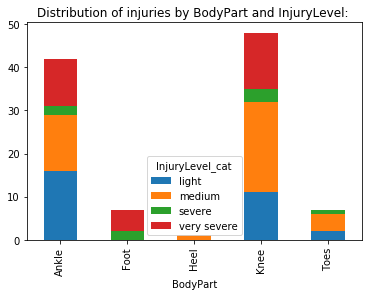

In [43]:
#let's see the distribution of injuries by BodyPart and InjuryLevel
injury_df.groupby(['InjuryLevel_cat','BodyPart']).count().unstack('InjuryLevel_cat')['PlayerKey']\
    .plot(kind='bar', title='Distribution of injuries by BodyPart and InjuryLevel: ', stacked=True)


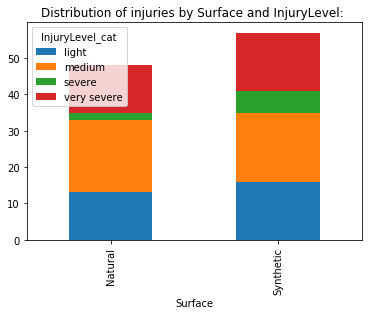

In [44]:
#let's see the distribution of injuries by Surface type and InjuryLevel (similar distribution)
injury_df.groupby(['InjuryLevel_cat','Surface']).count().unstack('InjuryLevel_cat')['PlayerKey']\
    .plot(kind='bar', title='Distribution of injuries by Surface and InjuryLevel: ', stacked=True)

In [45]:
#most of the injuries were in synthetic surface, but to check if it's significant factor we need to check all the games
#to check that we need to load another dataset - PlayList which is zipped

with zipfile.ZipFile("PlayList.csv.zip","r") as z:
    z.extractall(".")

play_list_df = pd.read_csv('PlayList.csv')
play_list_df.head()
#play_list_df.info()

,PlayerKey,GameID,PlayKey,RosterPosition,PlayerDay,PlayerGame,StadiumType,FieldType,Temperature,Weather,PlayType,PlayerGamePlay,Position,PositionGroup
0,26624,26624-1,26624-1-1,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Pass,1,QB,QB
1,26624,26624-1,26624-1-2,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Pass,2,QB,QB
2,26624,26624-1,26624-1-3,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Rush,3,QB,QB
3,26624,26624-1,26624-1-4,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Rush,4,QB,QB
4,26624,26624-1,26624-1-5,Quarterback,1,1,Outdoor,Synthetic,63,Clear and warm,Pass,5,QB,QB


In [46]:
#more game were played in natural surface whereas more injuries happened in synthetic surface
play_list_df[['GameID','FieldType']].groupby('GameID').min()['FieldType'].value_counts()

Natural      3311
Synthetic    2401
Name: FieldType, dtype: int64

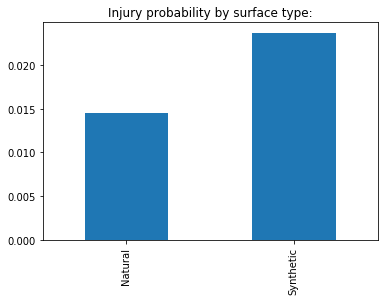

In [47]:
#we can see that percentage wise injuries are more probable on synthetic surface
inj_ratio = injury_df['Surface'].value_counts()/play_list_df[['GameID','FieldType']].groupby('GameID').\
    min()['FieldType'].value_counts()
inj_ratio.plot(kind='bar', title='Injury probability by surface type:')

In [48]:
#Some more info from PlayList dataset
unique_players_nr = play_list_df['PlayerKey'].nunique()
unique_players_nr
unique_games_nr = play_list_df['GameID'].nunique()
unique_games_nr
unique_plays_nr = play_list_df['PlayKey'].nunique()
unique_plays_nr
print('There are {} players in the dataset.'.format(unique_players_nr))
print('There are {} games in the dataset.'.format(unique_games_nr))
print('There are {} plays in the dataset.'.format(unique_plays_nr))

There are 250 players in the dataset.
There are 5712 games in the dataset.
There are 267005 plays in the dataset.


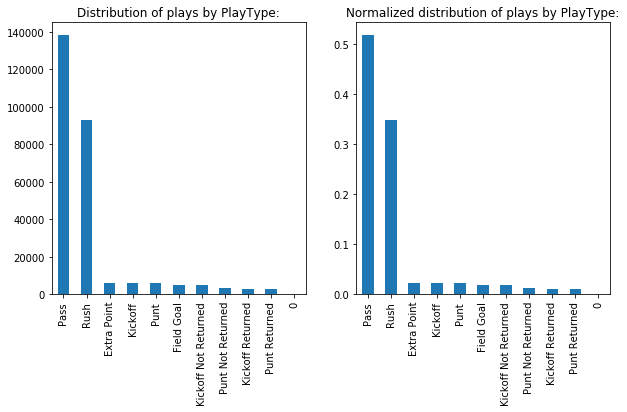

In [49]:
#distribution of plays by PlayType
plt.subplot(1,2,1)
play_list_df['PlayType'].value_counts().plot(kind='bar', title='Distribution of plays by PlayType:', figsize=(10,5))
#normalized
plt.subplot(1,2,2)
play_list_df['PlayType'].value_counts(normalize=True).plot(kind='bar', \
        title='Normalized distribution of plays by PlayType:', figsize=(10,5))
plt.show()

In [50]:
#StadiumType has 30 different values - this is way too much, we need to narrow it down
play_list_df['StadiumType'].value_counts()

Outdoor                   145032
Outdoors                   32956
Indoors                    22805
Dome                        9376
Retractable Roof            8914
Indoor                      6892
Open                        4124
Domed, closed               3076
Retr. Roof - Closed         2235
Retr. Roof-Closed           2015
Domed, open                 1779
Dome, closed                1059
Closed Dome                 1011
Domed                        985
Oudoor                       914
Domed, Open                  807
Ourdoor                      778
Outdoor Retr Roof-Open       601
Outddors                     595
Indoor, Roof Closed          547
Retr. Roof - Open            486
Retr. Roof-Open              486
Indoor, Open Roof            479
Bowl                         465
Retr. Roof Closed            414
Heinz Field                  389
Outdor                       356
Outside                      341
Cloudy                       178
Name: StadiumType, dtype: int64

In [51]:
#Let's bucket the stadiumTypes into 6 types: outdoor, indoor_closed, indoor_open, dome_closed, dome_open, unknown.
#We have significant value of 'unknown' StadiumType - data is missing
def map_stadium_type(x):
    if x in ['Outdoor', 'Outdoors', 'Cloudy', 'Heinz Field', 
              'Outdor', 'Ourdoor', 'Outside', 'Outddors', 
              'Outdoor Retr Roof-Open', 'Oudoor', 'Bowl']: return 'outdoor'
    if x in ['Indoors', 'Indoor', 'Indoor, Roof Closed', 'Indoor, Roof Closed',
                   'Retractable Roof', 'Retr. Roof-Closed', 'Retr. Roof - Closed', 'Retr. Roof Closed']: return 'indoor_closed'
    if x in ['Indoor, Open Roof', 'Open', 'Retr. Roof-Open', 'Retr. Roof - Open']: return 'indoor_open'
    if x in ['Dome', 'Domed, closed', 'Closed Dome', 'Domed', 'Dome, closed']: return 'dome_closed'
    if x in ['Domed, Open', 'Domed, open']: return 'dome_open'
    return 'unknown'

play_list_df['StadiumType_cat']=play_list_df['StadiumType'].map(lambda x: map_stadium_type(x))
play_list_df['StadiumType_cat'].value_counts()

outdoor          182605
indoor_closed     43822
unknown           16910
dome_closed       15507
indoor_open        5575
dome_open          2586
Name: StadiumType_cat, dtype: int64

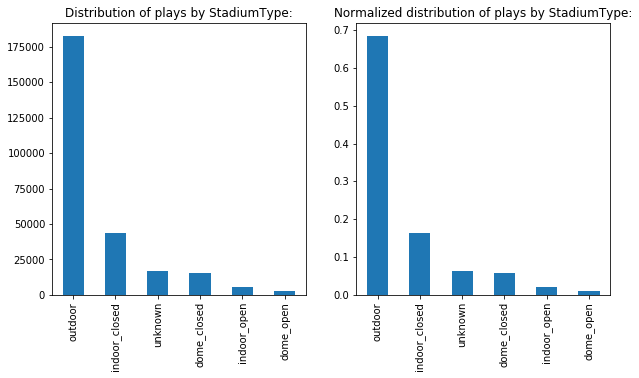

In [52]:
#distribution of plays by StadiumType
plt.subplot(1,2,1)
play_list_df['StadiumType_cat'].value_counts().plot(kind='bar', \
        title='Distribution of plays by StadiumType:', figsize=(10,5))
#normalized
plt.subplot(1,2,2)
play_list_df['StadiumType_cat'].value_counts(normalize=True).plot(kind='bar', \
        title='Normalized distribution of plays by StadiumType:', figsize=(10,5))
plt.show()

In [53]:
#Merge injury dataframe with playlist dataframe
injury_df_ext = injury_df.merge(play_list_df)
injury_df_ext.head()
#injury_df_ext.info()

,PlayerKey,GameID,PlayKey,BodyPart,Surface,DM_M1,DM_M7,DM_M28,DM_M42,InjuryLevel,InjuryLevel_cat,RosterPosition,PlayerDay,PlayerGame,StadiumType,FieldType,Temperature,Weather,PlayType,PlayerGamePlay,Position,PositionGroup,StadiumType_cat
0,39873,39873-4,39873-4-32,Knee,Synthetic,1,1,1,1,4,very severe,Linebacker,29,4,Indoors,Synthetic,84,Cloudy,Punt,32,OLB,LB,indoor_closed
1,46074,46074-7,46074-7-26,Knee,Natural,1,1,0,0,2,medium,Linebacker,50,7,Open,Natural,76,Partly Cloudy,Punt,26,OLB,LB,indoor_open
2,36557,36557-1,36557-1-70,Ankle,Synthetic,1,1,1,1,4,very severe,Safety,1,1,Outdoor,Synthetic,63,Clear and warm,Pass,70,SS,DB,outdoor
3,46646,46646-3,46646-3-30,Ankle,Natural,1,0,0,0,1,light,Linebacker,15,3,Outdoor,Natural,80,Cloudy,Punt,30,LB,LB,outdoor
4,43532,43532-5,43532-5-69,Ankle,Synthetic,1,1,1,1,4,very severe,Wide Receiver,32,5,Retractable Roof,Synthetic,89,Partly Cloudy,Kickoff,69,WR,WR,indoor_closed


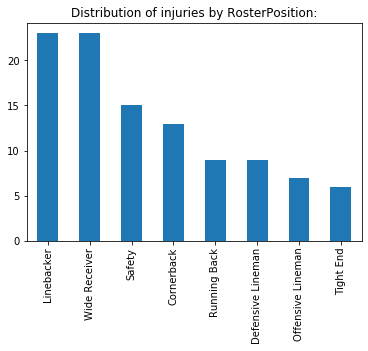

In [54]:
#ditribution of injuries by RosterPosition
injury_df_ext['RosterPosition'].value_counts().plot(kind='bar', title='Distribution of injuries by RosterPosition:')

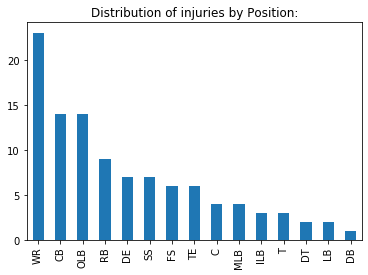

In [55]:
#ditribution of injuries by Position
injury_df_ext['Position'].value_counts().plot(kind='bar', title='Distribution of injuries by Position:')

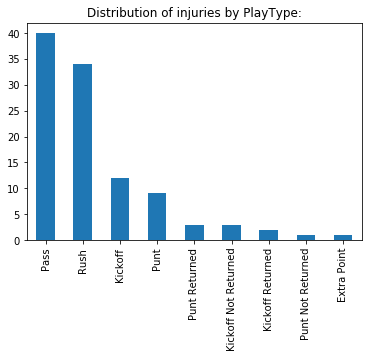

In [56]:
#ditribution of injuries by PlayType
injury_df_ext['PlayType'].value_counts().plot(kind='bar', title='Distribution of injuries by PlayType:')

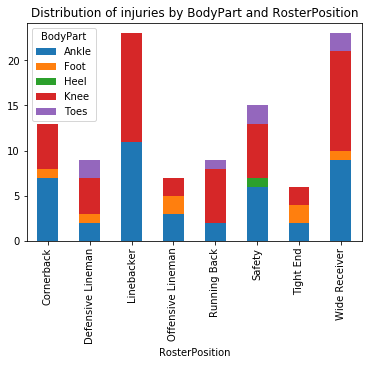

In [57]:
#distribution of injury types by RosterPosition
injury_df_ext.groupby(['RosterPosition','BodyPart']).count().unstack('BodyPart')['PlayerKey']\
    .plot(kind='bar', title='Distribution of injuries by BodyPart and RosterPosition', stacked=True)

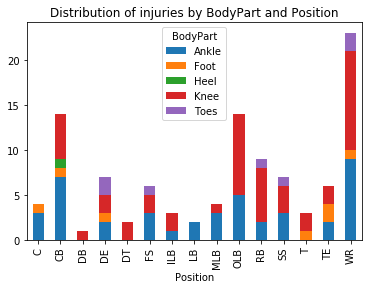

In [58]:
#distribution of injury types by Position
injury_df_ext.groupby(['Position','BodyPart']).count().unstack('BodyPart')['PlayerKey']\
    .plot(kind='bar', title='Distribution of injuries by BodyPart and Position', stacked=True)

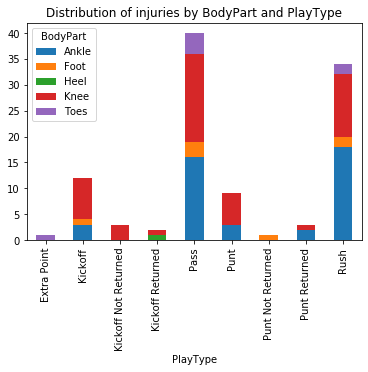

In [59]:
#distribution of injury types by PlayType
injury_df_ext.groupby(['PlayType','BodyPart']).count().unstack('BodyPart')['PlayerKey']\
    .plot(kind='bar', title='Distribution of injuries by BodyPart and PlayType', stacked=True)

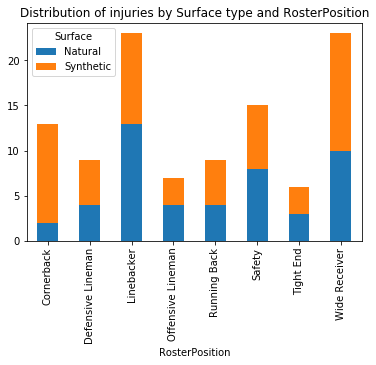

In [60]:
#distribution of injury types by Surface type
injury_df_ext.groupby(['RosterPosition','Surface']).count().unstack('Surface')['PlayerKey']\
    .plot(kind='bar', title='Distribution of injuries by Surface type and RosterPosition', stacked=True)

In [61]:
injury_df_ext['PlayerGamePlay'].median()

13.0

In [62]:
play_list_df[['GameID','PlayerGamePlay']].groupby('GameID').max()['PlayerGamePlay'].mean()

46.744572829131656

Median time of injury on synthetic surface is 15.0 play of the game:


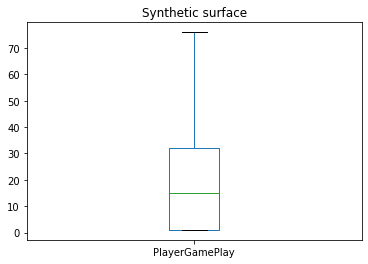

Median time of injury on natural surface is 12.5 play of the game:


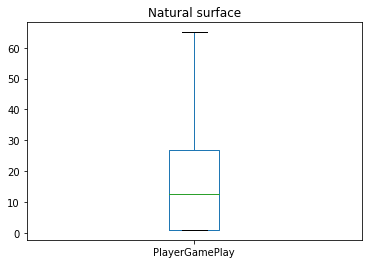

In [63]:
#let's see distribution of injuries through game type for natural and synthetic surface (similar)
inj=injury_df_ext[['FieldType', 'PlayerGamePlay']]
inj1=inj[inj['FieldType']=='Synthetic']
print('Median time of injury on synthetic surface is {} play of the game:'.format(inj1['PlayerGamePlay'].median()))
inj1.plot(kind='box', title='Synthetic surface')
plt.show()

inj2= inj[inj['FieldType']=='Natural']
print('Median time of injury on natural surface is {} play of the game:'.format(inj2['PlayerGamePlay'].median()))
inj2.plot(kind='box', title='Natural surface')
plt.show()

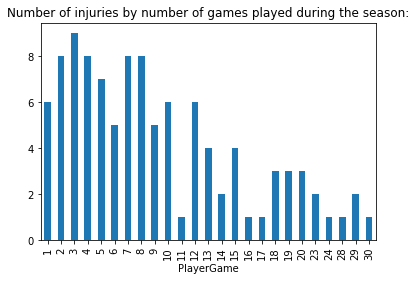

In [64]:
#We can see a trend that the number of injuries is decreasing through season games
nr_injuries=injury_df_ext.groupby('PlayerGame').count()['PlayerKey']
nr_injuries.plot(kind='bar', title='Number of injuries by number of games played during the season:')

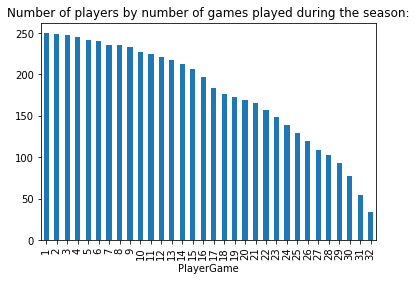

In [65]:
#but the number of players that play is also decreasing 
nr_plays = play_list_df[['PlayerKey','PlayerGame']].drop_duplicates().groupby('PlayerGame').count()['PlayerKey']
nr_plays.plot(kind='bar', title='Number of players by number of games played during the season:')

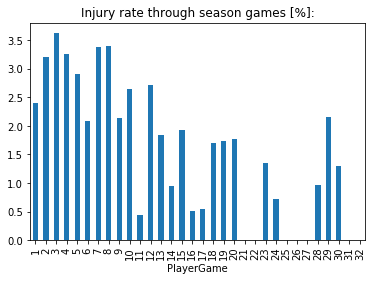

In [66]:
#let's create a diagram with injury rate through season games
injury_ratio_percent = (nr_injuries/nr_plays*100)
injury_ratio_percent.plot(kind='bar', title='Injury rate through season games [%]:')

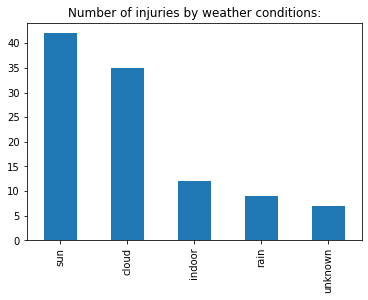

In [67]:
#let's check if weather has impact on injury rate
#first we need to categorize the weather description

def map_weather_type(x):
    if x in ['30% Chance of Rain', 'Rainy', 'Rain Chance 40%', 'Showers', 'Cloudy, 50% change of rain', 'Rain likely, temps in low 40s.',
          'Cloudy with periods of rain, thunder possible. Winds shifting to WNW, 10-20 mph.',
          'Scattered Showers', 'Cloudy, Rain', 'Rain shower', 'Light Rain', 'Rain']: return 'rain'
    if x in ['Party Cloudy', 'Cloudy, chance of rain','Coudy',
              'Cloudy and cold', 'Cloudy, fog started developing in 2nd quarter',
              'Partly Clouidy', 'Mostly Coudy', 'Cloudy and Cool',
              'cloudy', 'Partly cloudy', 'Overcast', 'Hazy', 'Mostly cloudy', 'Mostly Cloudy',
              'Partly Cloudy', 'Cloudy']: return 'cloud'
    if x in ['Partly clear', 'Sunny and clear', 'Sun & clouds', 'Clear and Sunny',
           'Sunny and cold', 'Sunny Skies', 'Clear and Cool', 'Clear and sunny',
           'Sunny, highs to upper 80s', 'Mostly Sunny Skies', 'Cold',
           'Clear and warm', 'Sunny and warm', 'Clear and cold', 'Mostly sunny',
           'T: 51; H: 55; W: NW 10 mph', 'Clear Skies', 'Clear skies', 'Partly sunny',
           'Fair', 'Partly Sunny', 'Mostly Sunny', 'Clear', 'Sunny']: return 'sun'
    if x in ['Cloudy, light snow accumulating 1-3"', 'Heavy lake effect snow', 'Snow']: return 'snow'
    if x in ['N/A Indoor', 'Indoors', 'Indoor', 'N/A (Indoors)', 'Controlled Climate']: return 'indoor'
    return 'unknown'

injury_df_ext['Weather_cat']=injury_df_ext['Weather'].map(lambda x: map_weather_type(x))
injury_df_ext['Weather_cat'].value_counts().plot(kind='bar', title='Number of injuries by weather conditions:')

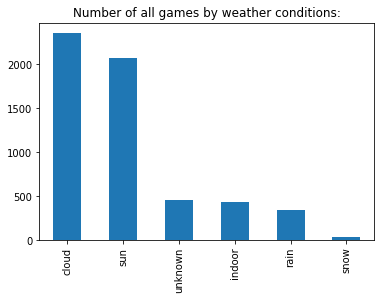

In [68]:
play_list_df['Weather_cat']=play_list_df['Weather'].map(lambda x: map_weather_type(x))
play_list_df[['PlayerKey','PlayerGame','Weather_cat']].drop_duplicates()\
['Weather_cat'].value_counts().plot(kind='bar', title='Number of all games by weather conditions:')

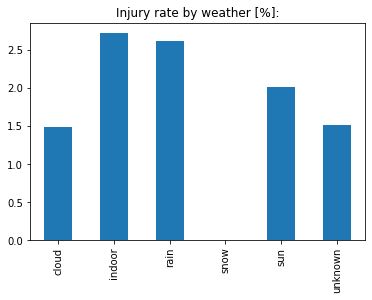

In [69]:
inj_weather = injury_df_ext['Weather_cat'].value_counts()
allgames_weather = play_list_df[['PlayerKey','PlayerGame','Weather_cat']].drop_duplicates()['Weather_cat'].value_counts()
inj_weather_ratio_percent = (inj_weather/allgames_weather*100)
inj_weather_ratio_percent.plot(kind='bar', title='Injury rate by weather [%]:')


PLAYER TRACKING DATA

In [0]:
#let's load last dataset and take closer look at the data
with zipfile.ZipFile("PlayerTrackData.csv.zip","r") as z:
    z.extractall(".")

player_track_data_df = pd.read_csv('PlayerTrackData.csv')
#player_track_data_df.info()

In [71]:
player_track_data_df.head(10)

,PlayKey,time,event,x,y,dir,dis,o,s
0,26624-1-1,0.0,huddle_start_offense,87.46,28.93,288.24,0.01,262.33,0.13
1,26624-1-1,0.1,NaN,87.45,28.92,283.91,0.01,261.69,0.12
2,26624-1-1,0.2,NaN,87.44,28.92,280.40,0.01,261.17,0.12
3,26624-1-1,0.3,NaN,87.44,28.92,278.79,0.01,260.66,0.10
4,26624-1-1,0.4,NaN,87.44,28.92,275.44,0.01,260.27,0.09
5,26624-1-1,0.5,NaN,87.45,28.92,270.06,0.01,260.08,0.07
6,26624-1-1,0.6,NaN,87.46,28.92,265.05,0.01,260.05,0.05
7,26624-1-1,0.7,NaN,87.46,28.92,255.75,0.00,260.28,0.02
8,26624-1-1,0.8,NaN,87.46,28.92,244.56,0.00,260.72,0.01
9,26624-1-1,0.9,NaN,87.46,28.92,220.57,0.00,261.26,0.01


In [0]:
#let's fill missing data in the 'event' column
player_track_data_df['event'].fillna(method='ffill', inplace=True)

In [73]:
#we have 80 types of events, we need to categorize them somehow
player_track_data_df['event'].nunique()
#player_track_data_df['event'].unique()

80

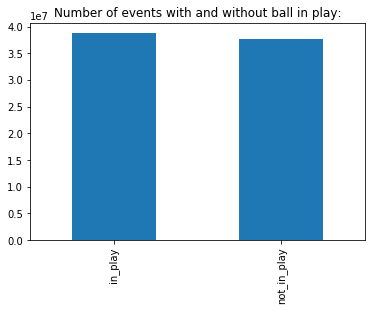

In [0]:
#let's add column in_play to indicate whether event was with ball in play or not
#i'm not football expert so there might be a misenterpretation here
def map_event_type(x):
    if x in ["tackle", "ball_snap", "pass_outcome_incomplete", "out_of_bounds", "first_contact", "handoff", 
             "pass_forward", "pass_outcome_caught", "touchdown", "qb_sack", "touchback", "kickoff", "punt", 
             "pass_outcome_touchdown", "pass_arrived", "extra_point", "field_goal", "play_action", "kick_received", 
             "fair_catch", "punt_downed", "run", "punt_received", "qb_kneel", "pass_outcome_interception", 
             "field_goal_missed", "fumble", "fumble_defense_recovered", "qb_spike", "extra_point_missed", 
             "fumble_offense_recovered", "pass_tipped", "lateral", "qb_strip_sack", "safety", "kickoff_land", 
             "snap_direct", "kick_recovered", "field_goal_blocked", "punt_muffed", "pass_shovel", "extra_point_blocked", 
             "pass_lateral", "punt_blocked", "run_pass_option", "free_kick", "punt_fake", "end_path", "drop_kick", 
             "field_goal_fake", "extra_point_fake", "xp_fake"]: return 'in_play'
    return 'not_in_play'

player_track_data_df['in_play']=player_track_data_df['event'].map(lambda x: map_event_type(x))
#we can see that categorization we created separated the data into similar size categories
player_track_data_df['in_play'].value_counts().plot(kind='bar', title='Number of events with and without ball in play:')

In [0]:
#let's merge both datasets
track_injury_df = player_track_data_df.merge(injury_df, how='left')
#and create new boolean column ['IsInjured']
track_injury_df['IsInjured']=track_injury_df['PlayerKey']>0

In [78]:
#let's delete not needed columns
blacklist = ['PlayerKey', 'GameID', 'BodyPart', 'Surface', 'DM_M1', 'DM_M7',
       'DM_M28', 'DM_M42', 'InjuryLevel', 'InjuryLevel_cat']
for feat in blacklist:
    del track_injury_df[feat]

NameError: ignored

In [0]:
track_injury_df['IsInjured_num']=track_injury_df['IsInjured'].map(lambda x: int(x))
track_injury_df.head()

In [0]:
#let's save all datasets for next part - classification:)
injury_df_ext.to_csv('injury_df_ext.csv', index=False)
play_list_df.to_csv('play_list_df.csv', index=False)
track_injury_df.to_csv('track_injury_df.csv', index=False)

In [0]:
#function to create football field visualization copied from Rob Mulla
#https://www.kaggle.com/robikscube/nfl-big-data-bowl-plotting-player-position

def create_football_field(linenumbers=True,
                          endzones=True,
                          highlight_line=False,
                          highlight_line_number=50,
                          highlighted_name='Line of Scrimmage',
                          fifty_is_los=False,
                          figsize=(12, 6.33)):
    """
    Function that plots the football field for viewing plays.
    Allows for showing or hiding endzones.
    """
    rect = patches.Rectangle((0, 0), 120, 53.3, linewidth=0.1,
                             edgecolor='r', facecolor='darkgreen', zorder=0)

    fig, ax = plt.subplots(1, figsize=figsize)
    ax.add_patch(rect)

    plt.plot([10, 10, 10, 20, 20, 30, 30, 40, 40, 50, 50, 60, 60, 70, 70, 80,
              80, 90, 90, 100, 100, 110, 110, 120, 0, 0, 120, 120],
             [0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3,
              53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 53.3, 0, 0, 53.3],
             color='white')
    if fifty_is_los:
        plt.plot([60, 60], [0, 53.3], color='gold')
        plt.text(62, 50, '<- Player Yardline at Snap', color='gold')
    # Endzones
    if endzones:
        ez1 = patches.Rectangle((0, 0), 10, 53.3,
                                linewidth=0.1,
                                edgecolor='r',
                                facecolor='blue',
                                alpha=0.2,
                                zorder=0)
        ez2 = patches.Rectangle((110, 0), 120, 53.3,
                                linewidth=0.1,
                                edgecolor='r',
                                facecolor='blue',
                                alpha=0.2,
                                zorder=0)
        ax.add_patch(ez1)
        ax.add_patch(ez2)
    plt.xlim(0, 120)
    plt.ylim(-5, 58.3)
    plt.axis('off')
    if linenumbers:
        for x in range(20, 110, 10):
            numb = x
            if x > 50:
                numb = 120 - x
            plt.text(x, 5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='white')
            plt.text(x - 0.95, 53.3 - 5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='white', rotation=180)
    if endzones:
        hash_range = range(11, 110)
    else:
        hash_range = range(1, 120)

    for x in hash_range:
        ax.plot([x, x], [0.4, 0.7], color='white')
        ax.plot([x, x], [53.0, 52.5], color='white')
        ax.plot([x, x], [22.91, 23.57], color='white')
        ax.plot([x, x], [29.73, 30.39], color='white')

    if highlight_line:
        hl = highlight_line_number + 10
        plt.plot([hl, hl], [0, 53.3], color='yellow')
        plt.text(hl + 2, 50, '<- {}'.format(highlighted_name),
                 color='yellow')
    return fig, ax

NameError: ignored

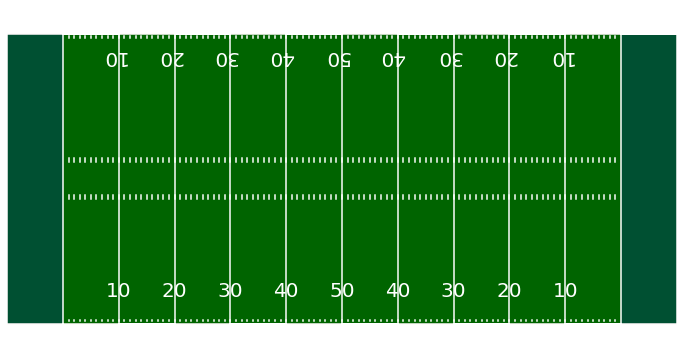

In [76]:
#let's visualize some example path of one injured player
example_play_id = injury_df_ext['PlayKey'].values[16]
fig, ax = create_football_field()
track_injury_df[track_injury_df['PlayKey']==example_play_id].plot(kind='scatter', x='x', y='y', ax=ax, color='orange')
plt.show()

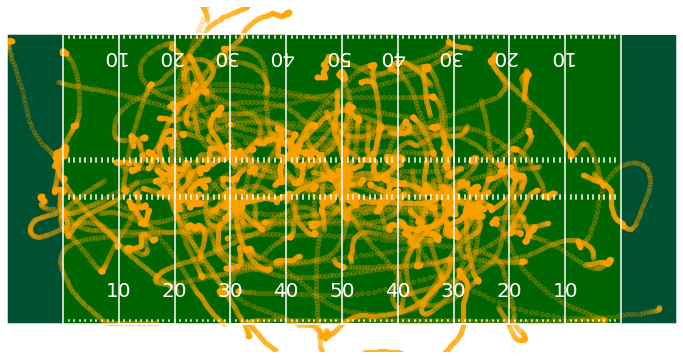

In [77]:
#visualization of all paths of injured players
#not really helpful, but nice to see :)
inj_play_list = injury_df_ext['PlayKey'].tolist()
fig, ax = create_football_field()
for playkey, inj_play in player_track_data_df.query('PlayKey in @inj_play_list').groupby('PlayKey'):
    inj_play.plot(kind='scatter', x='x', y='y', ax=ax, color='orange', alpha=0.2)
plt.show()

In [85]:
cd "/content/drive/My Drive/Colab Notebooks/NFL data visualization/NFL-injury-dataset"

/content/drive/My Drive/Colab Notebooks/NFL data visualization/NFL-injury-dataset


In [83]:
ls

 ColabDriveGithub.ipynb   NFL-injury-dataset/
 Data/                   'NFL injury data visualization.ipynb'
 kaggle.json


In [84]:
!git add 'NFL injury data visualization.ipynb'

fatal: not a git repository (or any parent up to mount point /content)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).
